In [1]:
import tables, glob, os, time, sys
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import axes3d, Axes3D
import multiprocessing
from functools import partial
import datetime
import matplotlib.colors as colors
from scipy.stats import norm

In [2]:
class LightMap(object):
    def __init__(self, Input):
        self.Data = {}
        self.Meta = {}
        self.Files = Input.files
        self.Num = Input.num
        self.Colors = ['#1f78b4', '#e66101', '#33a02c', '#984ea3', 'grey', 
                        'k', '#F27781', '#18298C', '#04BF8A', '#F2CF1D', 
                        '#F29F05', '#7155D9', '#8D07F6', '#9E91F2', '#F29B9B', 
                        '#F25764', '#6FB7BF', '#B6ECF2', '#5D1314', '#B3640F']
        self.AllKeys = ['Origin', 'LastHitTriangle', 'IncidentAngles', 'DetectorHit', 
                        'Flags', 'FinalPosition', 'NumDetected']

    def GetPhotonFlags(self, Flags):
        PhotonFlags = {}
        PhotonFlags['NO_HIT'] = (Flags & (0x1 << 0)).astype(bool)   
        PhotonFlags['BULK_ABSORB'] = (Flags & (0x1 << 1)).astype(bool)   
        PhotonFlags['SURFACE_DETECT'] = (Flags & (0x1 << 2)).astype(bool)   
        PhotonFlags['SURFACE_ABSORB'] = (Flags & (0x1 << 3)).astype(bool)   
        PhotonFlags['RAYLEIGH_SCATTER'] = (Flags & (0x1 << 4)).astype(bool)   
        PhotonFlags['REFLECT_DIFFUSE'] = (Flags & (0x1 << 5)).astype(bool)   
        PhotonFlags['REFLECT_SPECULAR'] = (Flags & (0x1 << 6)).astype(bool)    
        PhotonFlags['SURFACE_REEMIT'] = (Flags & (0x1 << 7)).astype(bool)    
        PhotonFlags['SURFACE_TRANSMIT'] = (Flags & (0x1 << 8)).astype(bool)    
        PhotonFlags['BULK_REEMIT'] = (Flags & (0x1 << 9)).astype(bool)   
        PhotonFlags['MATERIAL_REFL'] = (Flags & (0x1 << 10)).astype(bool)  
        PhotonFlags['NAN_ABORT'] = (Flags & (0x1 << 31)).astype(bool)  
        return PhotonFlags

    def Reshape(self): 
        self.Data['Origin'] = np.reshape(self.Data['Origin'], (-1,3))
        self.Data['NumDetected'] = self.Data['NumDetected'].flatten()
        if 'FinalPosition' in self.Data.keys():
            self.Data['FinalPosition'] = np.reshape(self.Data['FinalPosition'], (-1, self.Meta['NumberOfPhotons'],3))
            self.Data['Flags'] = np.reshape(self.Data['Flags'], (-1, self.Meta['NumberOfPhotons']))
        # if 'DetectorHit' in self.Data.keys():
        #     self.Data['DetectorHit'] = np.reshape(self.Data['DetectorHit'], (-1, self.Meta['NumberOfPhotons'],3))
        if 'LastHitTriangle' in self.Data.keys():
            self.Data['LastHitTriangle'] = np.reshape(self.Data['LastHitTriangle'], (-1, self.Meta['NumberOfPhotons']))

    def ReadFile(self, Keys, File): 
        if not os.path.isfile(File):
            return
        else: 
            Data = {}
            try:
                with tables.open_file(File, mode="r") as f: 
                    for Key in Keys:    
                        data = f.root._f_get_child(Key)._f_get_child(Key).read()
                        if data is None:
                            print(data)
                        Data[Key] = data
                if Data is None: 
                    print(Data)
                return(Data)
            except:
                return 

    def GetData(self, Keys, Files, Multi=False):
        Print('Number of Files', len(Files))
        t0 = time.time()
        for keys in Keys: 
            if keys in self.AllKeys:
                pass 
            else: 
                print('data for \'%s\' not available...make sure that the key is spelled correctly' % keys)
                sys.exit()

        AllData = []
        self.GetMetaData()
        if Multi: 
            Print('Importing Data in Parallel', '')
            pool = multiprocessing.Pool()
            func = partial(self.ReadFile, Keys)
            AllData = pool.map(func, Files) 
        else:
            Print('Importing Data in Serial', '')
            for ii, File in enumerate(self.Files):  
                Data = self.ReadFile(Keys, File)
                AllData.append(Data)
                ProgressBar(ii, len(self.Files), '  Importing Data')    
        Print('Time for importing data in sec', time.time()-t0)
        self.Data = {}
        for Key in Keys: 
            Print('Merging data for key', Key)
            self.Data[Key] = np.concatenate(list(d[Key] for d in AllData if d is not None))
            Print('Status','Done')
        Print('=')

    def GetMetaData(self):
        Print('=')
        for File in self.Files[:1]:
            with tables.open_file(File, mode="r") as f:
                for x in f.root._v_attrs._f_list():
                    self.Meta[x] = f.root._v_attrs[x]
                    try:
                        Print(str(x), str(self.Meta[x].decode('UTF-8')))
                    except:
                        Print(str(x), str(self.Meta[x]))

    def PrintEfficiency(self): 
        self.Data['Efficiency'] = self.Data['NumDetected']/np.mean(self.Meta['NumberOfPhotons'])*100.0
        self.Data['Efficiency'] = self.Data['Efficiency'].flatten()
        # Print(self.Data['NumDetected'], np.mean(self.Meta['NumberOfPhotons']))
        if 'nEXO' in str(self.Meta['DetectorName']):
            self.Data['Efficiency'] *= 0.84
        Print('Average Efficiency', np.round(np.mean(self.Data['Efficiency']),2))  
        Print('Average Efficiency Error', np.round(np.std(self.Data['Efficiency'])/np.sqrt(np.sum(self.Meta['NumberOfSources'])),2))  

def GetFiles(Path='', arg=''):
    files = []
    if arg == '': 
        files.append(glob.glob(Path))
    else: 
        if (arg.dirpath != None):
            for dir in arg.dirpath:
                files.append(glob.glob(dir+'*.h5'))
        if (arg.filepath != None):
            files.append(arg.filepath)
    files = [val for sublist in files for val in sublist]
    Print('Number of files', len(files))
    return files


In [27]:
def ReadFile(Keys, File): 
    if not os.path.isfile(File):
        print('no')
        return
    else: 
        Data = {}
        try:
            with tables.open_file(File, mode="r") as f: 
                for Key in Keys:    
                    data = f.root._f_get_child(Key)._f_get_child(Key).read()
                    if data is None:
                        print(data)
                    Data[Key] = data
            if Data is None: 
                print(Data)
            return(Data)
        except:
            return 

In [41]:
Keys1 = ['Origin', 'LastHitTriangle', 'IncidentAngles', 'DetectorHit', 
                        'Flags', 'FinalPosition', 'NumDetected']

# File1 = "..\chroma_nEXO_OD_OD_test_210527_164627_r3326.h5"
File1 = "..\chroma_nEXO_OD_OD_test_210528_114859_r7131.h5"

Data1 = ReadFile(Keys1, File1)

In [42]:
print(Data1.keys())

print(Data1['NumDetected'])

AttributeError: 'NoneType' object has no attribute 'keys'

In [51]:
Divergence = 1.
Diameter = .01

maxAngle = Divergence/2 
deltaZ = -(Diameter/2)/np.tan(maxAngle)

print(deltaZ)

-0.00915243860856226


## Looking at photon paths

In [2]:
from stl import mesh
from mpl_toolkits import mplot3d

In [78]:
def readPhotonPaths(filename):

    f = open(filename, "r")
    paths1 = [[],[],[]]
    paths = []
    save = -1

    lst = f.read().splitlines()
    f.close()

    num_lines = len(lst)

    # print(lst)

    for i in range(1, num_lines, 4):
    #     line = lst[i]
    #     print(lst[i+1])

        X = [float(x) for x in lst[i+1].split(', ')[:-1]]
        Y = [float(x) for x in lst[i+2].split(', ')[:-1]]
        Z = [float(x) for x in lst[i+3].split(', ')[:-1]]


        paths.append([X, Y, Z])
    return paths

In [80]:
paths = readPhotonPaths("photonPath_PMTcheck1.txt")


In [90]:
#STL files for plotting

#watertank
WT_mesh = mesh.Mesh.from_file('CAD/ODModel_SimulationModelUpdatedCryostat v14_simplified_WT_1_WaterTank_simplified_WT.STL')
WT_mesh.rotate([-1, 0.0, 0.0], np.radians(90))

#outer cyrostat
OC_mesh = mesh.Mesh.from_file('CAD/ODModel_OuterCyrostat.STL')
OC_mesh.rotate([-1, 0.0, 0.0], np.radians(90))

#PMT glass surface
PMT_mesh = mesh.Mesh.from_file('CAD/ODModel_PMT_Glassware_Component2Body1_Component2.STL')
PMT_mesh.rotate([-1, 0.0, 0.0], np.radians(90))

#PMT Steel connecting parts
PMT1_mesh = mesh.Mesh.from_file('CAD/ODModel_PMT_MetalConnection_Component3Body1_Component3.STL')
PMT2_mesh = mesh.Mesh.from_file('CAD/ODModel_PMT_MetalConnection_Component4Body1_Component4.STL')
# PMT3_mesh = mesh.Mesh.from_file('CAD/ODModel_PMT_MetalConnection_Component6Body1_Component6.STL') #metal prongs
PMTcon_mesh = mesh.Mesh(np.concatenate([m.data for m in [PMT1_mesh, PMT2_mesh]] ))
PMTcon_mesh.rotate([-1, 0.0, 0.0], np.radians(90))


listofParts = [WT_mesh, OC_mesh, PMT_mesh, PMTcon_mesh]
colors = ['black', 'black', 'darkred', 'blue']
alpha = [0.05, 0.1, 0.1, 0.1]
facecolor = [None, 'yellow', "red", None]

"""
Function to graph only wanted part of the geometry, with placement and coloring 
already configured.

parts - list of parts to graph, default is 'all' which graphs all parts, otherwise choose out
    of: ['WT', 'OC', 'PMTGlass', 'PMTconnect']
"""
def addGeometry(ax, parts='all'):
    
    if parts=='all':
        plotPart = np.arange(len(listofParts))
    else:
        plotPart = []
        for p in parts:
            if p=='WT':
                plotPart.append(0)
            elif p=='OC':
                plotPart.append(1)
            elif p=='PMTGlass':
                plotPart.append(2)
            elif p=='PMTconnect':
                plotPart.append(3)
#             elif p=='support':
#                 plotPart.append(4)
                
    for i in plotPart:
            
        geometryPart = mplot3d.art3d.Line3DCollection(listofParts[i].vectors, linewidths=0.2, alpha=alpha[i])
        geometryPart.set_edgecolor(colors[0])
        geometryPart.set_facecolor(facecolor[i])
        ax.add_collection3d(geometryPart)

1.8834153413772583 0.7112779021263123 -6752.7490234375


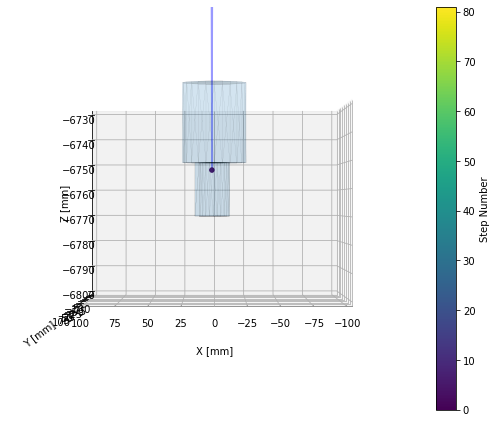

In [102]:
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

for i in range(len(paths[:1])):
    direction = np.arange(len(paths[i][0]))#, len(paths[i][0]))

    axes.plot3D(paths[i][0], paths[i][1], paths[i][2], 'blue', alpha=0.4)
    p = axes.scatter3D(paths[i][0], paths[i][1], paths[i][2], c=direction, cmap='viridis') #, vmin=0, vmax=ELs_max)
    
    print(paths[i][0][1], paths[i][1][1], paths[i][2][1])    
    
addGeometry(axes, parts=['PMTconnect']) #'PMTGlass', 

axes.set_xlim3d(-100, 100)
axes.set_ylim3d(-100, 100)
axes.set_zlim3d(-6800, -6730)

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15
# axes.zaxis.labelpad=15

fig.colorbar(p, label="Step Number", shrink=0.8)

#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(0, 90)

# 0, 90 - XZ plane; 90, 90 - top view


plt.show()